In [11]:
# %matplotlib notebook
# import matplotlib.pyplot as plt

In [1]:
import numpy as np
import scipy as sc
import numpy.linalg as npl
from numpy.linalg import norm
import scipy.linalg as scl
from scipy.spatial.distance import pdist,squareform
import ase
from tqdm import tqdm_notebook as tqdm_cs

In [16]:
%matplotlib notebook
import numpy as np
import pylab as plt

import tabulate
from ipywidgets import Label, Button, Output, FloatSlider, HBox, VBox, Layout, HTML, Accordion, interactive, interactive_output
from widget_code_input import WidgetCodeInput
from IPython.display import display

In [3]:
from tools import manipulation_hist,manipulation_LJ_force,manipulation_Harmonique_force,manipulation_LJ,get_numerical_force,manipulation_Harmonique
from tools import visualiser_trajectoire,faire_une_chaine_circulaire,faire_une_chaine_lineaire

# Developper les fonctions pour modeliser une chaine de polymere

<img src="figures/r2_r1-01.png" width="250" height="250" />

## Potentiel harmonique

Le potentiel harmonique est donné par:

$V_{har}\,\left(d\right) = k \,\left(d-r_m\right)^2,$

où $d$ est la longueur du ressort, $r_m$ est la longueur du ressort au repos et $k$ est la constante de raideur du ressort.
Si les extrémités du ressort sont données par les vecteurs $\vec{r_1} = \left(x_1,\, y_1,\,  z_1\right)$ et $\vec{r_2} = \left(x_2,\, y_2,\,  z_2\right)$ respectivement, alors $d=\sqrt{(x_1-x_2)^2+(y_1-y_2)^2+(z_1-z_2)^2}$.


In [18]:


def check_user_value(code_widget, check_function_output, reference_func, test_values_dict):
    import itertools
    # I don't catch exceptions so that the users can see the traceback
    error_string = "YOUR FUNCTION DOES NOT SEEM RIGHT, PLEASE TRY TO FIX IT"
    ok_string = "YOUR FUNCTION SEEMS TO BE CORRECT!! CONGRATULATIONS!"
    
    test_table = []
    last_exception = None
    type_warning = False
    
    check_function_output.clear_output(wait=True)
    with check_function_output:
        user_function = code_widget.get_function_object() 

             
        for test_vals in itertools.product(*test_values_dict.values()):
            input_dict = {k:v for k,v in zip(test_values_dict.keys(),test_vals)}
            correct_value = reference_func(**input_dict)
            try:
                user_value = user_function(**input_dict)
                try:
                    error = abs(user_value - correct_value)
                except Exception:
                    type_warning = True
                    error = 1. # Large value so it triggers a failed test
            except Exception as exc:
                last_exception = exc
                test_table.append(list(test_vals)+[correct_value, "ERROR", False])
            else:
                if error > 1.e-8:
                    test_table.append(list(test_vals)+[str(correct_value), str(user_value), False])
                else:
                    test_table.append(list(test_vals)+[str(correct_value), str(user_value), True])

        num_tests = len(test_table)
        num_passed_tests = len([test for test in test_table if test[5]])
        failed_tests = [test[:-1] for test in test_table if not test[5]] # Keep only failed tests, and remove last column
        MAX_FAILED_TESTS = 5
        if num_passed_tests < num_tests:
            html_table = HTML("<style>tbody tr:nth-child(odd) { background-color: #e2f7ff; } th { background-color: #94cae0; min-width: 100px; } td { font-family: monospace; } td, th { padding-right: 3px; padding-left: 3px; } </style>" + 
                             tabulate.tabulate(
                                 failed_tests[:MAX_FAILED_TESTS], 
                                 tablefmt='html',
                                 headers=["d", "r_m", "k", "Expected value", "Your value"]
                             ))
                
        if num_passed_tests < num_tests:
            print("Your function does not seem correct; only {}/{} tests passed".format(num_passed_tests, num_tests))
            print("Printing up to {} failed tests:".format(MAX_FAILED_TESTS))
            display(html_table)
        else:
            print("Your function is correct! Very good! All {} tests passed".format(num_tests))
        
        if type_warning:
            print("WARNING! in at least one case, your function did not return a valid float number, please double check!".format(num_tests))
    
        # Raise the last exception obtained
        if last_exception is not None:
            print("I obtained at least one exception")
            raise last_exception from None
                        
def get_user_value(code_widget, check_function_output, sliders_dict, **kwargs):
    """
    This function returns the value computed by the user's
    function for the current sliders' value, or None if there is an exception
    """
    kwargs.update({k:slider.value for k,slider in sliders_dict.items()})
    with check_function_output:
        user_function = code_widget.get_function_object() 
        try:
            user_values = user_function(**kwargs)
        except Exception as exc:
            return None
    return user_values        

In [19]:


def get_precompute(setup_class):
    
    code_widget = setup_class.code_widget
    check_function_output = setup_class.check_function_output
    reference_func = setup_class.reference_func
    test_values_dict = setup_class.test_values_dict
    sliders_dict = setup_class.sliders_dict
    widgets = setup_class.widgets
    replot = setup_class.replot
    
    def recompute(e):
        if e is not None:
            if e['type'] != 'change' or e['name'] not in ['value', 'function_body']:
                return     
        replot_kwargs = {k:slider.value for k,slider in sliders_dict.items()}
        replot(**replot_kwargs)

        # Print info on the "correctness" of the user's function
        check_user_value(code_widget, check_function_output, reference_func, test_values_dict)
    
    
    for widget in widgets:
        widget.observe(recompute)
        
    return recompute

In [30]:
class SetUpHarmonicPotential(object):
    def __init__(self):        
        self.plot_box = Output()
        with self.plot_box:
            self.the_figure, self.the_plot = plt.subplots(figsize=(5,5))
            self.the_plot.set_xlabel("x [l]")
            self.the_plot.set_xlabel("Potentiel [e]")
        
        # set up the value checker
        self.check_function_output = Output()
        self.check_accordion = Accordion(children=[self.check_function_output], selected_index=None)
        self.check_accordion.set_title(0, 'Validation de ta fonction (clique pour voir le résultat)')
        
        # set up the sliders
        r_m_widget = FloatSlider(
            value=2, min=0.50, max=5,step=0.2,
            description=r'\(r_m\)',
            continuous_update=False, 
            style={'description_width': 'initial'}, layout=Layout(width='50%', min_width='350px'))
        k_widget = FloatSlider(
            value=2, min=0.50, max=5,step=0.2,
            description=r'\(k\)',
            continuous_update=False, 
            style={'description_width': 'initial'}, layout=Layout(width='50%', min_width='350px'))
        self.sliders_dict = dict(r_m=r_m_widget,k=k_widget)
        
        # set up the test values
        self.test_values_dict = dict(d=[1,2,3,4],r_m=[1,3],k=[2,3])
        
        # set upt the code widget window
        self.code_widget = WidgetCodeInput(
            function_name="Potentiel_Harmonique", 
            function_parameters="d, r_m, k",
            docstring="""
        Implémente l'énergie potentielle associée à un ressort

        :param d: distance [l]
        :param r_m: distance de repos du ressort [l]
        :param k: force du ressort [e/l] 

        :return: Valeur de l'énergie potentielle du ressort [e]
        """,
            function_body="# Ecrit ta solution\n# Après avoir modifié la fonction, déplace un des sliders pour valider ta solution")
        
        self.widgets = [slider for slider in self.sliders_dict.values()]
        self.widgets += [self.code_widget]
        
        self.input_box = VBox([slider for slider in self.sliders_dict.values()])
        # self.plot = interactive_output(self.replot, self.sliders_dict)
    
    def display(self):
        display(self.code_widget)
        display(self.input_box,self.the_figure)
        display(self.check_accordion)
        
    def reference_func(self,d,r_m,k):
        ### Retourne la valeur du potentiel harmonique
        return k*( d - r_m)**2
    
    def replot(self, r_m, k):
        # Clean up the graph
        self.the_plot.axes.clear()

        circle1 = plt.Circle((0, 2), 0.2, color='b')
        circle2 = plt.Circle((r_m, 2), 0.2, color='r')
        self.the_plot.add_artist(circle1)
        self.the_plot.add_artist(circle2)
        r = np.linspace(-2, 6, num=100)
        self.the_plot.plot(r, self.reference_func(r,r_m,k))


        # plt.show()
        ## (Try to) plot user value
        user_value = None
        try:
            user_value = get_user_value(**{'d',r})
        except Exception:
            # Just a guard not to break the visualization, we should not end up here
            pass 
        try:
            if user_value is not None:
                self.the_plot.plot([user_value], [0], 'or')    
        except Exception:
            # We might end up here if the function does not return a float value
            pass 

        self.the_plot.set_xlim(-0.5,4)
        self.the_plot.set_ylim(-0.5,4)
        # Redraw
        self.the_figure.canvas.draw()
        self.the_figure.canvas.flush_events()


WidgetCodeInput(docstring="\n        Implémente l'énergie potentielle associée à un ressort\n\n        :param …

<IPython.core.display.Javascript object>


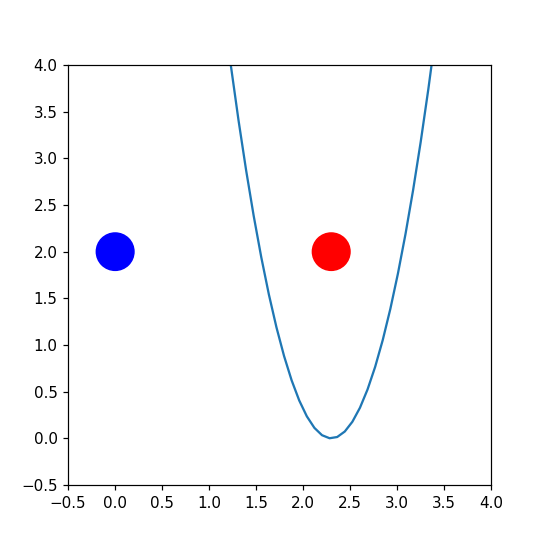

Accordion(children=(Output(),), selected_index=None, _titles={'0': 'Validation de ta fonction (clique pour voi…

In [31]:
setup_class = SetUpHarmonicPotential()

recompute = get_precompute(setup_class)

_ = recompute(None)

setup_class.display()




In [42]:
code_widget = WidgetCodeInput(
    function_name="Potentiel_Harmonique", 
    function_parameters="d, r_m, k",
    docstring="""
Implémente l'énergie potentielle associée à un ressort

:param d: distance [l]
:param r_m: distance de repos du ressort [l]
:param k: force du ressort [e/l] 
    
:return: Valeur de l'énergie potentielle du ressort [e]
""",
    function_body="# Ecrit ta solution\n# Après avoir modifié la fonction, déplace un des sliders pour valider ta solution")
# display(code_widget)

In [5]:
r_m_widget = FloatSlider(
    value=2, min=0.50, max=5,step=0.2,
    description=r'\(r_m\)',
    continuous_update=False, 
    style={'description_width': 'initial'}, layout=Layout(width='50%', min_width='350px'))
k_widget = FloatSlider(
    value=2, min=0.50, max=5,step=0.2,
    description=r'\(k\)',
    continuous_update=False, 
    style={'description_width': 'initial'}, layout=Layout(width='50%', min_width='350px'))

plot_box = Output()

input_box = VBox([r_m_widget, k_widget])
# display(HBox([input_box, plot_box]))

In [6]:
check_function_output = Output()
check_accordion = Accordion(children=[check_function_output], selected_index=None)
check_accordion.set_title(0, 'Validation de ta fonction (clique pour voir le résultat)')

# display(check_accordion)

Accordion(children=(Output(),), selected_index=None, _titles={'0': 'Validation de ta fonction (clique pour voi…

In [7]:
def check_user_value():
    # I don't catch exceptions so that the users can see the traceback
    error_string = "YOUR FUNCTION DOES NOT SEEM RIGHT, PLEASE TRY TO FIX IT"
    ok_string = "YOUR FUNCTION SEEMS TO BE CORRECT!! CONGRATULATIONS!"
    
    test_table = []
    last_exception = None
    type_warning = False
    
    check_function_output.clear_output(wait=True)
    with check_function_output:
        user_function = code_widget.get_function_object() 

        test_values_d = [1,2,3,4]
        test_values_r_m = [1,3]
        test_values_k = [2,3]           
        for test_d in test_values_d:
            for test_r_m in test_values_r_m:
                for test_k in test_values_k:
                    correct_value = Potentiel_Harmonique(
                        d=test_d, 
                        r_m=test_r_m,
                        k=test_k
                    )
                    try:
                        user_hit_position = user_function(
                            d=test_d, 
                            r_m=test_r_m,
                            k=test_k
                        )
                        try:
                            error = abs(user_hit_position - correct_value)
                        except Exception:
                            type_warning = True
                            error = 1. # Large value so it triggers a failed test
                    except Exception as exc:
                        last_exception = exc
                        test_table.append([test_d, test_r_m, test_k, correct_value, "ERROR", False])
                    else:
                        if error > 1.e-8:
                            test_table.append([test_d, test_r_m, test_k, str(correct_value), str(user_hit_position), False])
                        else:
                            test_table.append([test_d, test_r_m, test_k, str(correct_value), str(user_hit_position), True])

        num_tests = len(test_table)
        num_passed_tests = len([test for test in test_table if test[5]])
        failed_tests = [test[:-1] for test in test_table if not test[5]] # Keep only failed tests, and remove last column
        MAX_FAILED_TESTS = 5
        if num_passed_tests < num_tests:
            html_table = HTML("<style>tbody tr:nth-child(odd) { background-color: #e2f7ff; } th { background-color: #94cae0; min-width: 100px; } td { font-family: monospace; } td, th { padding-right: 3px; padding-left: 3px; } </style>" + 
                             tabulate.tabulate(
                                 failed_tests[:MAX_FAILED_TESTS], 
                                 tablefmt='html',
                                 headers=["d", "r_m", "k", "Expected value", "Your value"]
                             ))
                
        if num_passed_tests < num_tests:
            print("Your function does not seem correct; only {}/{} tests passed".format(num_passed_tests, num_tests))
            print("Printing up to {} failed tests:".format(MAX_FAILED_TESTS))
            display(html_table)
        else:
            print("Your function is correct! Very good! All {} tests passed".format(num_tests))
        
        if type_warning:
            print("WARNING! in at least one case, your function did not return a valid float number, please double check!".format(num_tests))
    
        # Raise the last exception obtained
        if last_exception is not None:
            print("I obtained at least one exception")
            raise last_exception from None
                        
def get_user_value():
    """
    This function returns the value computed by the user's
    function for the current sliders' value, or None if there is an exception
    """
    with check_function_output:
        user_function = code_widget.get_function_object() 
        try:
            d = np.linspace(-2, 6, num=100)
            user_hit_position = user_function(
                d=d[50], 
                r_m=r_m_widget.value,
                k=k_widget.value
            )
        except Exception as exc:
            return None
    return user_hit_position        

In [8]:
def Potentiel_Harmonique(d,r_m,k):
    ### Retourne la valeur du potentiel harmonique
    return k*( d - r_m)**2

In [14]:
with plot_box:
    the_figure, the_plot = plt.subplots(figsize=(5,5))
    the_plot.set_xlabel("x [l]")
    the_plot.set_xlabel("Potentiel [e]")

def replot(r_m, k):
    global the_plot, g
    
    # fig, ax = plt.subplots(figsize=(5,5))
    # Clean up the graph
    the_plot.axes.clear()
    
    circle1 = plt.Circle((0, 2), 0.2, color='b')
    circle2 = plt.Circle((r_m, 2), 0.2, color='r')
    the_plot.add_artist(circle1)
    the_plot.add_artist(circle2)
    r = np.linspace(-2, 6, num=100)
    the_plot.plot(r, Potentiel_Harmonique(r,r_m,k))

    
    # plt.show()
    ## (Try to) plot user value
    user_value = None
    try:
        user_value = get_user_value()
    except Exception:
        # Just a guard not to break the visualization, we should not end up here
        pass 
    try:
        if user_value is not None:
            the_plot.plot([user_value], [0], 'or')    
    except Exception:
        # We might end up here if the function does not return a float value
        pass 
    
    the_plot.set_xlim(-0.5,4)
    the_plot.set_ylim(-0.5,4)
    # Redraw
    the_figure.canvas.draw()
    the_figure.canvas.flush_events()

In [12]:
def recompute(e):
    global the_plot
    
    if e is not None:
        if e['type'] != 'change' or e['name'] not in ['value', 'function_body']:
            return     
    replot(
        r_m=r_m_widget.value, 
        k=k_widget.value,
    )
    
    # Print info on the "correctness" of the user's function
    check_user_value()
    
# Bind the sliders to the event
r_m_widget.observe(recompute)
k_widget.observe(recompute)

# Bind also the code widget
code_widget.observe(recompute)

In [13]:
# Perform the first recomputation (to create the plot)
_ = recompute(None)

In [ ]:
# def manipulation_Harmonique(func):
#     def f(r_m,k):
#         fig, ax = plt.subplots(figsize=(5,5))
#         circle1 = plt.Circle((0, 2), 0.2, color='b')
#         circle2 = plt.Circle((r_m, 2), 0.2, color='r')
#         ax.add_artist(circle1)
#         ax.add_artist(circle2)
#         r = np.linspace(-2, 6, num=100)
#         plt.plot(r, func(r,r_m,k))
        
#         plt.xlim(-0.5,4)
#         plt.ylim(-0.5,4)
#         plt.show()
#     return interactive(f, r_m=FloatSlider(min=0.5, max=5, step=0.2,description=r'\(r_m\)',value=2), 
#                        k=FloatSlider(min=0.5,max=5.,step=0.2,description=r'\(k\)',value=2))


In [5]:
### Change les parametres pour se familiariser avec la fonction
# manipulation_Harmonique(Potentiel_Harmonique)

interactive(children=(FloatSlider(value=2.0, description='\\(r_m\\)', max=5.0, min=0.5, step=0.2), FloatSlider…